In [161]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [162]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# 0. Carga de los datos

In [163]:
import os 
ruta = os.getcwd()
print(ruta)

c:\Users\oipli\Desktop\Inte Neg\Lab 1\BI-202302\Lab2


In [164]:
df_laptops_train = pd.read_csv('./data/laptop_data_train.csv', sep=',', encoding='utf-8')

In [165]:
df_laptops_train.shape
#

(1216, 14)

In [166]:
df_laptops_train.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
458,180,Dell,Notebook,16,2.02,10.931154,0,0,141.211998,Intel Core i7,2000.0,256,AMD,Others
238,770,Dell,Notebook,16,2.30,11.049906,0,0,141.211998,Intel Core i7,0.0,256,AMD,Windows
684,440,Lenovo,Notebook,8,2.80,10.227465,0,0,106.113062,AMD Processor,1000.0,0,AMD,Windows
489,1152,Lenovo,Notebook,8,2.32,10.370823,0,0,141.211998,Intel Core i5,1000.0,0,AMD,Others
1190,852,Dell,Notebook,8,2.83,10.738291,0,0,127.335675,Intel Core i7,1000.0,0,AMD,Others


In [167]:
df_laptops_unlabeled = pd.read_csv('./data/laptop_data_test_unlabeled.csv', sep=',', encoding='utf-8')

In [168]:
df_laptops_unlabeled.shape

(64, 14)

In [169]:
df_laptops_unlabeled.sample(5)

,id,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os,CalculatedPrice
12,64,HP,Notebook,8,1.86,0,0,141.211998,Intel Core i5,0.0,256,Intel,Windows,NaN
63,251,Asus,Gaming,16,4.30,0,0,127.335675,Intel Core i7,1000.0,256,Nvidia,Windows,NaN
38,1171,HP,Notebook,16,2.10,0,0,141.211998,Intel Core i7,0.0,512,Intel,Windows,NaN
22,228,Asus,Notebook,8,2.69,0,0,127.335675,Intel Core i5,500.0,256,Nvidia,Windows,NaN
4,739,Acer,Notebook,4,2.40,0,0,100.454670,Intel Core i3,500.0,0,Intel,Windows,NaN


In [170]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1216 non-null   int64  
 1   Company      1216 non-null   object 
 2   TypeName     1216 non-null   object 
 3   Ram          1216 non-null   int64  
 4   Weight       1193 non-null   float64
 5   Price        1201 non-null   float64
 6   TouchScreen  1216 non-null   int64  
 7   Ips          1216 non-null   int64  
 8   Ppi          1204 non-null   float64
 9   Cpu_brand    1216 non-null   object 
 10  HDD          1200 non-null   float64
 11  SSD          1216 non-null   int64  
 12  Gpu_brand    1216 non-null   object 
 13  Os           1216 non-null   object 
dtypes: float64(4), int64(5), object(5)
memory usage: 133.1+ KB


In [171]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1216 non-null   int64  
 1   Company      1216 non-null   object 
 2   TypeName     1216 non-null   object 
 3   Ram          1216 non-null   int64  
 4   Weight       1193 non-null   float64
 5   Price        1201 non-null   float64
 6   TouchScreen  1216 non-null   int64  
 7   Ips          1216 non-null   int64  
 8   Ppi          1204 non-null   float64
 9   Cpu_brand    1216 non-null   object 
 10  HDD          1200 non-null   float64
 11  SSD          1216 non-null   int64  
 12  Gpu_brand    1216 non-null   object 
 13  Os           1216 non-null   object 
dtypes: float64(4), int64(5), object(5)
memory usage: 133.1+ KB


# 1. Entendimiento y limpieza de los datos

In [172]:
# Eleccion de variables relevantes para calcular el precio de un computador
features = [
    'Company',
    'TypeName',
    'Ram',
    'Weight',
    'TouchScreen',
    'Ips',
    'Ppi',
    'Cpu_brand',
    'HDD',
    'SSD',
    'Gpu_brand',
    'Os'
]
featuresCategoricas = ['Company', 'TypeName', 'TouchScreen', 'Ips', 'Cpu_brand', 'Gpu_brand', 'Os']
featuresNumericas = ['Ram', 'Weight', 'Ppi', 'HDD', 'SSD']

# Eliminar variables no en features (id)
df_laptops_train = df_laptops_train[['Price'] + features]
df_laptops_unlabeled = df_laptops_unlabeled[features]


### 1.1. Verificacion de atributos de calidad de datos

#### Consistencia: Valores únicos en las variables categóricas

In [173]:
# verificar valores unicos en cada variable categorica
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation' '2 in 1 Convertible%%' 'Gaming%%' '&&Notebook'
 '&&Ultrabook' 'Notebook%%' '&&Gaming' '&&2 in 1 Convertible']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD' 'Intel%%' 'Nvidia%%' '&&Intel' '&&Nvidia' 'AMD%%'
 '&&AMD']
Os: ['Others' 'Windows' 'Mac']


**Resultados:** Se puede observar que las variables 'TypeName' y 'Gpu_brand' tienen valores con caracteres extraños. Se procederá a eliminarlos para corregir esta información.

In [174]:
# Eliminar caracteres "&&", "%%", en las variables categoricas 'TypeName' y 'Gpu_brand'


df_laptops_train['TypeName'] = df_laptops_train['TypeName'].str.replace('&&', '').str.replace('%%', '')
df_laptops_train['Gpu_brand'] = df_laptops_train['Gpu_brand'].str.replace('%%', '').str.replace('&&', '')


In [175]:
# verificar valores unicos en cada variable categorica de datos de test
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_unlabeled[feature].unique()}')
    

Company: ['HP' 'Lenovo' 'MSI' 'Asus' 'Acer' 'Toshiba' 'Dell' 'Mediacom']
TypeName: ['Notebook' 'Gaming' 'Ultrabook' '2 in 1 Convertible' 'Netbook'
 '&&Notebook']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'Other Intel Processor'
 'AMD Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Os: ['Windows' 'Others']


In [176]:
# Eliminar caracteres "&&", "%%", en las variables categoricas 'TypeName' y 'Gpu_brand' de datos de test
df_laptops_unlabeled['TypeName'] = df_laptops_unlabeled['TypeName'].str.replace('&&', '').str.replace('%%', '')
df_laptops_unlabeled['Gpu_brand'] = df_laptops_unlabeled['Gpu_brand'].str.replace('%%', '').str.replace('&&', '')

In [177]:
#Verificación de valores unicos en cada variable categorica luego de eliminar caracteres "&&", "%%"
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Os: ['Others' 'Windows' 'Mac']


In [178]:
# Verificar valores unicos en cada variable categorica de datos de test luego de eliminar caracteres "&&", "%%"
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_unlabeled[feature].unique()}')

Company: ['HP' 'Lenovo' 'MSI' 'Asus' 'Acer' 'Toshiba' 'Dell' 'Mediacom']
TypeName: ['Notebook' 'Gaming' 'Ultrabook' '2 in 1 Convertible' 'Netbook']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'Other Intel Processor'
 'AMD Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Os: ['Windows' 'Others']


Se corrigieron los valores con caracteres extraños.

In [179]:
# Función que compara la cantidad de valores únicos en cada variable categorica entre los datos de entrenamiento y los datos de test
def compararValoresUnicos(df_train, df_test, featuresCategoricas):
    for feature in featuresCategoricas:
        print(f'{feature}: {df_train[feature].unique()}')
        print(f'{feature}: {df_test[feature].unique()}')
        print(f'{feature}: {df_train[feature].unique().shape}')
        print(f'{feature}: {df_test[feature].unique().shape}')
        print('------------------------')

compararValoresUnicos(df_laptops_train, df_laptops_unlabeled, featuresCategoricas)
    

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
Company: ['HP' 'Lenovo' 'MSI' 'Asus' 'Acer' 'Toshiba' 'Dell' 'Mediacom']
Company: (19,)
Company: (8,)
------------------------
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation']
TypeName: ['Notebook' 'Gaming' 'Ultrabook' '2 in 1 Convertible' 'Netbook']
TypeName: (6,)
TypeName: (5,)
------------------------
TouchScreen: [0 1]
TouchScreen: [0 1]
TouchScreen: (2,)
TouchScreen: (2,)
------------------------
Ips: [0 1]
Ips: [0 1]
Ips: (2,)
Ips: (2,)
------------------------
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'Other Intel Processor'
 'AMD Processor']
Cpu_brand: (5,)
Cpu_brand: (5,)
------------------------
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Gpu_brand: ['Intel' 

In [180]:
# Función que compara la cantidad de registro por cada valor único en cada variable categorica entre los datos de entrenamiento y los datos de test
def compararCantidadRegistros(df_train, df_test, featuresCategoricas):
    for feature in featuresCategoricas:
        print("para la variable: ", feature)
        print(f'{feature}: {df_train[feature].value_counts()}')
        print(f'{feature}: {df_test[feature].value_counts()}')
        print('------------------------')
        
compararCantidadRegistros(df_laptops_train, df_laptops_unlabeled, featuresCategoricas)

para la variable:  Company
Company: Lenovo       281
Dell         276
HP           255
Asus         141
Acer          96
MSI           50
Toshiba       45
Apple         23
Samsung        8
Razer          7
Microsoft      6
Mediacom       6
Xiaomi         4
Vero           4
Fujitsu        3
Chuwi          3
LG             3
Google         3
Huawei         2
Name: Company, dtype: int64
Company: Dell        15
HP          13
Lenovo      13
Asus        10
Acer         5
MSI          4
Toshiba      3
Mediacom     1
Name: Company, dtype: int64
------------------------
para la variable:  TypeName
TypeName: Notebook              670
Gaming                196
Ultrabook             188
2 in 1 Convertible    112
Workstation            29
Netbook                21
Name: TypeName, dtype: int64
TypeName: Notebook              39
Gaming                 9
Ultrabook              8
2 in 1 Convertible     6
Netbook                2
Name: TypeName, dtype: int64
------------------------
para la variable:  

Se puede observar que el dataset de entrenamiento tiene más valores únicos en varias categorías que el dataset de prueba. Se procede a unir los registros de los valores únicos del dataset de entrenamiento que no se encuentran en el dataset de prueba. 

In [181]:
# Funcion que identifica valores unicos en dataset de entrenamiento que no están en dataset de prueba
def identificarValoresUnicos(df_train, df_test, featuresCategoricas)-> list:
    featuresDiferentes = {}
    for feature in featuresCategoricas:
        featuresDiferentes[feature] = np.setdiff1d(df_train[feature].unique(), df_test[feature].unique())
        # convertir array a lista
        featuresDiferentes[feature] = featuresDiferentes[feature].tolist()   
    # imprimir valores diferentes
    print(featuresDiferentes)
    return featuresDiferentes
    

    

In [182]:
# Verificar valores distintos entre los datos de entrenamiento y los datos de test
featuresDiferentes = identificarValoresUnicos(df_laptops_train, df_laptops_unlabeled, featuresCategoricas)


{'Company': ['Apple', 'Chuwi', 'Fujitsu', 'Google', 'Huawei', 'LG', 'Microsoft', 'Razer', 'Samsung', 'Vero', 'Xiaomi'], 'TypeName': ['Workstation'], 'TouchScreen': [], 'Ips': [], 'Cpu_brand': [], 'Gpu_brand': [], 'Os': ['Mac']}


In [183]:
# Backup de datasets
df_laptops_train_bk = df_laptops_train.copy()
df_laptops_unlabeled_bk = df_laptops_unlabeled.copy()

In [184]:
# volver al backup
df_laptops_train = df_laptops_train_bk.copy()
df_laptops_unlabeled = df_laptops_unlabeled_bk.copy()


In [185]:
# ver datos de entrenamiento
df_laptops_train.sample(5)

,Price,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
1075,11.254190,HP,Ultrabook,8,NaN,0,0,4947.212947,Intel Core i7,NaN,256,Intel,Windows
1171,11.799207,Dell,Ultrabook,16,1.21,1,1,331.264236,Intel Core i7,0.0,1000,Intel,Windows
178,10.071363,Dell,Notebook,4,2.20,0,0,100.454670,Other Intel Processor,500.0,0,Intel,Windows
442,11.458805,Dell,Workstation,8,2.23,0,0,141.211998,Intel Core i7,1000.0,0,Nvidia,Windows
907,10.720680,Asus,Notebook,4,2.37,0,0,100.454670,Intel Core i7,0.0,256,Intel,Windows


In [186]:
# Reemplazar valores de features desconocidos por "Others"


def reemplazarValoresDesconocidos(df_train, featuresCategoricas, featuresDiferentes):
    for feature in featuresCategoricas:
        # Verificar si ya existe la categoria "Others" en la variable categorica
        if feature == 'Os':
           df_train[feature] = df_train[feature].replace(featuresDiferentes[feature], 'Others')
        else:
            df_train[feature] = df_train[feature].replace(featuresDiferentes[feature], 'Others' + "_" + feature)
    return df_train

In [187]:
#Modificar valores
reemplazarValoresDesconocidos(df_laptops_train, featuresCategoricas, featuresDiferentes)


,Price,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
0,10.084809,Lenovo,Notebook,4,1.90,0,0,100.454670,Intel Core i3,500.0,0,Intel,Others
1,10.563111,Dell,Notebook,8,1.98,0,0,141.211998,Intel Core i5,1000.0,0,Intel,Others
2,11.064804,HP,Ultrabook,8,1.26,0,0,176.232574,Intel Core i5,0.0,256,Intel,Windows
3,10.977717,Asus,2 in 1 Convertible,12,2.26,1,0,141.211998,Intel Core i7,2000.0,512,Nvidia,Windows
4,11.550633,Dell,Ultrabook,8,1.21,1,1,331.264236,Intel Core i7,0.0,256,Intel,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,10.893771,HP,Notebook,8,1.64,0,0,157.350512,Intel Core i5,0.0,256,Intel,Windows
1212,9.950617,Dell,Notebook,4,2.20,0,0,100.454670,Other Intel Processor,500.0,0,Intel,Others
1213,11.395541,Lenovo,2 in 1 Convertible,8,1.80,1,1,157.350512,Intel Core i7,0.0,256,Intel,Windows
1214,10.082584,Asus,Notebook,4,2.00,0,0,100.454670,Other Intel Processor,1000.0,0,Intel,Windows


In [188]:
# Verificar cantidad de valores unicos en cada variable categorica luego de agrupar valores diferentes en "Others"
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')
    print(f'{feature}: {df_laptops_train[feature].unique().shape}')
    print('------------------------')
    

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Others_Company'
 'Mediacom']
Company: (9,)
------------------------
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Others_TypeName']
TypeName: (6,)
------------------------
TouchScreen: [0 1]
TouchScreen: (2,)
------------------------
Ips: [0 1]
Ips: (2,)
------------------------
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Cpu_brand: (5,)
------------------------
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Gpu_brand: (3,)
------------------------
Os: ['Others' 'Windows']
Os: (2,)
------------------------


In [189]:
print(identificarValoresUnicos(df_laptops_train, df_laptops_unlabeled, featuresCategoricas))

{'Company': ['Others_Company'], 'TypeName': ['Others_TypeName'], 'TouchScreen': [], 'Ips': [], 'Cpu_brand': [], 'Gpu_brand': [], 'Os': []}
{'Company': ['Others_Company'], 'TypeName': ['Others_TypeName'], 'TouchScreen': [], 'Ips': [], 'Cpu_brand': [], 'Gpu_brand': [], 'Os': []}


Se han unido todos los valores desconocidos en una sola categoria "Others" en cada variable categorica

#### Completitud: Revisar valores nulos

In [190]:
# Revisión del porcentaje de valores nulos (vacíos) en cada columna

df_laptops_train[['Price']+ features].isnull().sum() / df_laptops_train.shape[0]

Price          0.012336
Company        0.000000
TypeName       0.000000
Ram            0.000000
Weight         0.018914
TouchScreen    0.000000
Ips            0.000000
Ppi            0.009868
Cpu_brand      0.000000
HDD            0.013158
SSD            0.000000
Gpu_brand      0.000000
Os             0.000000
dtype: float64

In [191]:
# Eliminar entradas con datos vacíos
# Antes de realizar el drop, se genera un informe con los datos que se van a eliminar
# .isnull() es igual a .isna()
def generarInformeDatosVacios(df_train, features):
    entradas_a_eliminar = df_train[df_train[['Price']+ features].isna().any(axis=1)]
    entradas_a_eliminar.to_csv('./data/entradas_a_eliminar.csv', sep=',', encoding='utf-8', index=False)
    return entradas_a_eliminar


In [192]:
# Eliminar entradas con datos vacíos
df_laptops_train = df_laptops_train.dropna(subset=['Price']+ features)
#df_laptops_test_unlabeled = df_laptops_unlabeled.dropna(subset=features)

In [193]:
df_laptops_train.shape

(1170, 13)

In [194]:
# Ya no es necesario contemplar dataset de test sin etiquetas
#df_laptops_test_unlabeled.shape

In [195]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1215
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        1170 non-null   float64
 1   Company      1170 non-null   object 
 2   TypeName     1170 non-null   object 
 3   Ram          1170 non-null   int64  
 4   Weight       1170 non-null   float64
 5   TouchScreen  1170 non-null   int64  
 6   Ips          1170 non-null   int64  
 7   Ppi          1170 non-null   float64
 8   Cpu_brand    1170 non-null   object 
 9   HDD          1170 non-null   float64
 10  SSD          1170 non-null   int64  
 11  Gpu_brand    1170 non-null   object 
 12  Os           1170 non-null   object 
dtypes: float64(4), int64(4), object(5)
memory usage: 128.0+ KB


In [196]:
# df_laptops_unlabeled.info()
# Ya no es necesario contemplar dataset de test sin etiquetas

In [197]:
# Revisión del porcentaje de valores nulos (vacíos) en cada columna luego de eliminar entradas con datos vacíos
df_laptops_train[['Price']+ features].isnull().sum() / df_laptops_train.shape[0]

Price          0.0
Company        0.0
TypeName       0.0
Ram            0.0
Weight         0.0
TouchScreen    0.0
Ips            0.0
Ppi            0.0
Cpu_brand      0.0
HDD            0.0
SSD            0.0
Gpu_brand      0.0
Os             0.0
dtype: float64

In [198]:
# Ya no es necesario contemplar dataset de test sin etiquetas
# Revision del porcentaje de valores nulos (vacíos) en cada columna luego de eliminar entradas con datos vacíos en datos unlabeled
# df_laptops_test_unlabeled[features].isnull().sum() / df_laptops_test_unlabeled.shape[0]

#### Unicidad: Entradas iguales en todas sus variables

In [199]:
# Unicidad de los datos de entrenamiento
entradas_duplicadas_train = df_laptops_train[df_laptops_train.duplicated()]
len(entradas_duplicadas_train)

4

In [200]:
# Ya no es necesario contemplar dataset de test sin etiquetas
# Unicidad de los datos no etiquetados
# entradas_duplicadas_unlabeled = df_laptops_test_unlabeled[df_laptops_test_unlabeled.duplicated()]
# len(entradas_duplicadas_unlabeled)

In [201]:
# Eliminar entradas duplicadas en datos de entrenamiento. 
# No se encontraron duplicados en datos unlabeled
def eliminarEntradasDuplicadas(df_train):
    df_train = df_train.drop_duplicates()
    return df_train



In [202]:
df_laptops_train = eliminarEntradasDuplicadas(df_laptops_train)

In [203]:
# Revisión de entradas duplicadas luego de eliminarlas
entradas_duplicadas = df_laptops_train[df_laptops_train.duplicated()]
len(entradas_duplicadas)

0

#### Validez: Rango lógico y formato correcto de valores en variables numéricas

In [204]:
# Revisar la validez de los datos de las variables numericas y la variable price en el dataset de entrenamiento
df_laptops_train[featuresNumericas + ['Price']].describe()


,Ram,Weight,Ppi,HDD,SSD,Price
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,8.507719,2.132753,151.778302,414.802744,187.989708,12.385126
std,5.136040,2.882080,181.493944,517.624081,187.302367,24.476793
min,2.000000,0.690000,90.583402,0.000000,0.000000,9.134616
25%,4.000000,1.500000,127.335675,0.000000,0.000000,10.402328
50%,8.000000,2.040000,141.211998,0.000000,256.000000,10.882316
75%,8.000000,2.310000,157.350512,1000.000000,256.000000,11.288115
max,64.000000,97.729949,6170.032609,2000.000000,1024.000000,499.766079


In [205]:
df_laptops_train[featuresNumericas + ['Price']].describe()

,Ram,Weight,Ppi,HDD,SSD,Price
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,8.507719,2.132753,151.778302,414.802744,187.989708,12.385126
std,5.136040,2.882080,181.493944,517.624081,187.302367,24.476793
min,2.000000,0.690000,90.583402,0.000000,0.000000,9.134616
25%,4.000000,1.500000,127.335675,0.000000,0.000000,10.402328
50%,8.000000,2.040000,141.211998,0.000000,256.000000,10.882316
75%,8.000000,2.310000,157.350512,1000.000000,256.000000,11.288115
max,64.000000,97.729949,6170.032609,2000.000000,1024.000000,499.766079


In [206]:
# Ya no es necesario contemplar dataset de test sin etiquetas
#df_laptops_test_unlabeled[featuresNumericas].describe()

In [207]:
# Revisar la cantidad de registros por valor en cada variable categorica
# En desuso
for feature in featuresCategoricas:
    print("Data train")
    print(f'{feature}: {df_laptops_train[feature].value_counts()}')
    print('------------------------')


Data train
Company: Lenovo            268
Dell              268
HP                241
Asus              137
Acer               92
Others_Company     62
MSI                48
Toshiba            44
Mediacom            6
Name: Company, dtype: int64
------------------------
Data train
TypeName: Notebook              644
Gaming                192
Ultrabook             177
2 in 1 Convertible    106
Others_TypeName        28
Netbook                19
Name: TypeName, dtype: int64
------------------------
Data train
TouchScreen: 0    999
1    167
Name: TouchScreen, dtype: int64
------------------------
Data train
Ips: 0    836
1    330
Name: Ips, dtype: int64
------------------------
Data train
Cpu_brand: Intel Core i7            482
Intel Core i5            380
Intel Core i3            125
Other Intel Processor    123
AMD Processor             56
Name: Cpu_brand, dtype: int64
------------------------
Data train
Gpu_brand: Intel     637
Nvidia    369
AMD       160
Name: Gpu_brand, dtype: int64


#### Output del archivo actual

In [208]:
nombre_archivo = 'df_laptops_train_output1.csv'
df_laptops_train.to_csv('./data/' + nombre_archivo, sep=',', encoding='utf-8', index=False)
#nombre_archivo_unlabeled = 'df_laptops_test_unlabeled_output1.csv'
#df_laptops_test_unlabeled.to_csv('./data/' + nombre_archivo_unlabeled, sep=',', encoding='utf-8', index=False)

#####

# 2. Búsqueda de relaciones entre variables

In [209]:
# Revisar valores unicos en cada variable categorica
# for feature in featuresCategoricas:
#     print(f'{feature}: {df_laptops_test_unlabeled[feature].unique()}')

### 2.1. Transformación de datos One Hot Encoder

In [210]:
# Transformar variables categoricas a numericas usando OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')


In [211]:
# Ajustar el encoder con los datos de entrenamiento
df_encoded_train = ohe.fit_transform(df_laptops_train[featuresCategoricas])

# Ajustar el encoder con los datos no etiquetados
# df_encoded_unlabeled = ohe.transform(df_laptops_test_unlabeled[featuresCategoricas])

In [212]:
# Convertir los resultados en DataFrame
df_encoded_train = pd.DataFrame(df_encoded_train, columns=ohe.get_feature_names_out(featuresCategoricas))
# df_encoded_unlabeled = pd.DataFrame(df_encoded_unlabeled, columns=ohe.get_feature_names_out(featuresCategoricas))

In [213]:
# Revisar el resultado
df_encoded_train.head()
# df_encoded_unlabeled.head()


,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [214]:
# back up de los datos de entrenamiento y no etiquetados
df_laptops_train_backup = df_laptops_train.copy()
# df_laptops_test_unlabeled_backup = df_laptops_test_unlabeled.copy()

# Volver a back up de los datos de entrenamiento y no etiquetados
#df_laptops_train = df_laptops_train_backup.copy()
#df_laptops_test_unlabeled = df_laptops_test_unlabeled_backup.copy()

In [215]:
# Concatenar los datos numericos con los datos categoricos codificados

# Resetear los indices de los dataframes de datos etiquetados
df_laptops_train = df_laptops_train.reset_index(drop=True) # resetear los indices del dataframe de datos de entrenamiento con variables numericas
df_encoded_train = df_encoded_train.reset_index(drop=True)  # resetear los indices del dataframe de datos de entrenamiento con variables categoricas codificadas
# Concatenar los dataframes
df_laptops_train = pd.concat([df_laptops_train.drop(featuresCategoricas, axis=1), df_encoded_train], axis=1)

# Resetear los indices de los dataframes de datos no etiquetados
# df_laptops_test_unlabeled = df_laptops_test_unlabeled.reset_index(drop=True)
# df_encoded_unlabeled = df_encoded_unlabeled.reset_index(drop=True)
# Concatenar los dataframes
# df_laptops_test_unlabeled_copy = pd.concat([df_laptops_test_unlabeled.drop(featuresCategoricas, axis=1), df_encoded_unlabeled], axis=1)


#df_laptops_train = pd.concat([df_laptops_train.drop(featuresCategoricas, axis=1), df_encoded_train], axis=1)
#df_laptops_test_unlabeled = pd.concat([df_laptops_test_unlabeled.drop(featuresCategoricas, axis=1), df_encoded_test], axis=1)


In [216]:
# Verificar que no hayan valores nulos en los datos de entrenamiento a causa del concatenado
rows_with_nan = df_laptops_train[df_laptops_train.isnull().any(axis=1)]
rows_with_nan


,Price,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows


In [217]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            1166 non-null   float64
 1   Ram                              1166 non-null   int64  
 2   Weight                           1166 non-null   float64
 3   Ppi                              1166 non-null   float64
 4   HDD                              1166 non-null   float64
 5   SSD                              1166 non-null   int64  
 6   Company_Asus                     1166 non-null   float64
 7   Company_Dell                     1166 non-null   float64
 8   Company_HP                       1166 non-null   float64
 9   Company_Lenovo                   1166 non-null   float64
 10  Company_MSI                      1166 non-null   float64
 11  Company_Mediacom                 1166 non-null   float64
 12  Company_Others_Compa

In [218]:
# df_laptops_test_unlabeled_copy.info()

### 2.2. Normalización de las variables

In [219]:
#scaler = StandardScaler()

# Ajustar el scaler con los datos de entrenamiento
#scaler.fit(df_laptops_train[featuresNumericas])

In [220]:
### Warning ###
# Backup de los datos de entrenamiento y test
df_laptops_train_copy_backup = df_laptops_train.copy()
#df_laptops_test_unlabeled_copy_backup = df_laptops_train.copy()


In [221]:
# vistazo al backup si hay valores nulos
rows_with_nan = df_laptops_train_copy_backup[df_laptops_train_copy_backup.isnull().any(axis=1)]
rows_with_nan


,Price,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows


In [222]:
# Transformar los conjuntos de datos
#df_laptops_train[featuresNumericas] = scaler.transform(df_laptops_train[featuresNumericas])
# df_laptops_test_unlabeled_copy[featuresNumericas] = scaler.transform(df_laptops_test_unlabeled_copy[featuresNumericas])


In [223]:
# Mostrar la info solo de las variables numericas
#df_laptops_train[featuresNumericas].head(1)

In [224]:
# Revisar el resultado
#df_laptops_train.describe()

In [225]:
# Revisar unicamente columna Price
#df_laptops_train['Price'].describe()

array([[<Axes: title={'center': 'Ram'}>,
        <Axes: title={'center': 'Weight'}>],
       [<Axes: title={'center': 'Ppi'}>, <Axes: title={'center': 'HDD'}>],
       [<Axes: title={'center': 'SSD'}>, <Axes: >]], dtype=object)

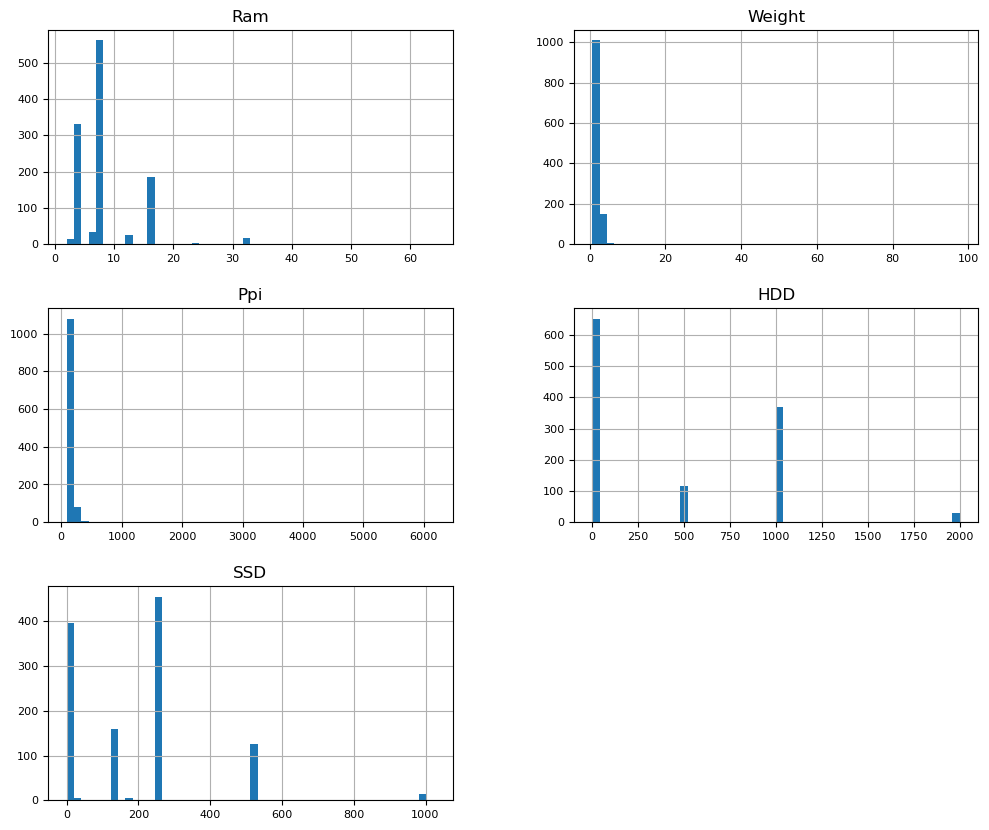

In [226]:
# histograma de cada variable numerica
df_laptops_train[featuresNumericas].hist(figsize=(12, 10), bins=50, xlabelsize=8, ylabelsize=8)


# 3. Ajustar un primer modelo

In [227]:

featuresActualizadas = list(df_laptops_train.columns)
featuresActualizadas.remove('Price')
X_train, X_test, y_train, y_test = train_test_split(df_laptops_train[featuresActualizadas], df_laptops_train['Price'], test_size = 0.2, random_state = 1)
print(featuresActualizadas)


['Ram', 'Weight', 'Ppi', 'HDD', 'SSD', 'Company_Asus', 'Company_Dell', 'Company_HP', 'Company_Lenovo', 'Company_MSI', 'Company_Mediacom', 'Company_Others_Company', 'Company_Toshiba', 'TypeName_Gaming', 'TypeName_Netbook', 'TypeName_Notebook', 'TypeName_Others_TypeName', 'TypeName_Ultrabook', 'TouchScreen_1', 'Ips_1', 'Cpu_brand_Intel Core i3', 'Cpu_brand_Intel Core i5', 'Cpu_brand_Intel Core i7', 'Cpu_brand_Other Intel Processor', 'Gpu_brand_Intel', 'Gpu_brand_Nvidia', 'Os_Windows']


In [228]:
# revisar datos de entrenamiento
X_train.describe()

,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows
count,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000
mean,8.512876,2.160697,153.395565,404.506438,190.098712,0.123391,0.222103,0.199571,0.238197,0.040773,0.004292,0.050429,0.038627,0.166309,0.012876,0.546137,0.027897,0.151288,0.148069,0.284335,0.108369,0.317597,0.424893,0.107296,0.538627,0.330472,0.860515
std,5.230544,3.205303,202.048254,508.257351,184.661885,0.329062,0.415883,0.399892,0.426209,0.197869,0.065407,0.218946,0.192807,0.372558,0.112798,0.498134,0.164766,0.358521,0.355359,0.451339,0.311013,0.465792,0.494592,0.309656,0.498773,0.470636,0.346638
min,2.000000,0.690000,90.583402,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.530000,127.335675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,8.000000,2.050000,141.211998,0.000000,256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,8.000000,2.322500,157.350512,1000.000000,256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,64.000000,97.729949,6170.032609,2000.000000,1024.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [229]:
# Mostrar filas con valores nulos
X_train[X_train.isnull().any(axis=1)]


,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows


In [230]:
regression = LinearRegression()

In [231]:
# revision de valores NaN existentes en el dataset
X_train.isnull().sum()


Ram                                0
Weight                             0
Ppi                                0
HDD                                0
SSD                                0
Company_Asus                       0
Company_Dell                       0
Company_HP                         0
Company_Lenovo                     0
Company_MSI                        0
Company_Mediacom                   0
Company_Others_Company             0
Company_Toshiba                    0
TypeName_Gaming                    0
TypeName_Netbook                   0
TypeName_Notebook                  0
TypeName_Others_TypeName           0
TypeName_Ultrabook                 0
TouchScreen_1                      0
Ips_1                              0
Cpu_brand_Intel Core i3            0
Cpu_brand_Intel Core i5            0
Cpu_brand_Intel Core i7            0
Cpu_brand_Other Intel Processor    0
Gpu_brand_Intel                    0
Gpu_brand_Nvidia                   0
Os_Windows                         0
d

In [232]:
regression.fit(X_train, y_train)

LinearRegression()

### 3.1. Interpretación de los coeficientes y el intercepto

In [233]:
pd.DataFrame(regression.coef_, index=X_train.columns, columns=['Coeficiente'])

,Coeficiente
Ram,-0.227906
Weight,-0.058025
Ppi,-0.000609
HDD,0.002653
SSD,0.018837
Company_Asus,1.332533
Company_Dell,1.155555
Company_HP,3.585654
Company_Lenovo,3.370169
Company_MSI,3.379897


In [234]:
regression.intercept_

-1.5383122210284697

<Axes: >

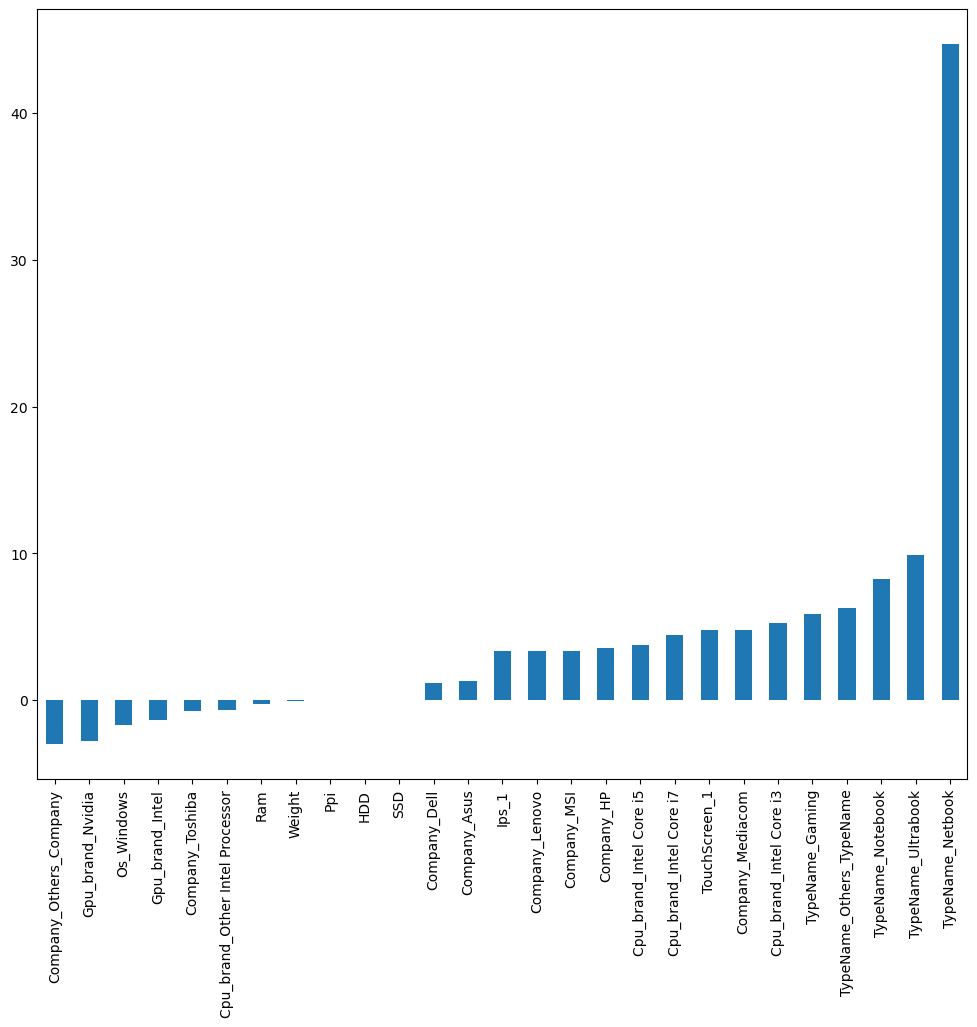

In [235]:

# Gráfico de barras de los coeficientes ordenados de mayor a menor ignorando Price
pd.Series(regression.coef_, index=X_train.columns).sort_values().plot(kind='bar', figsize=(12, 10))


# 4. Validar modelo

### 4.1. Prueba de significancia

In [236]:
# Prueba de significancia individual de las variables. 
# Se utiliza el p-value para determinar si la variable es significativa o no
# Si el p-value es menor a 0.05, la variable es significativa, es decir, tiene un efecto sobre la variable dependiente
# Si el p-value es mayor a 0.05, la variable no es significativa, es decir, no tiene un efecto sobre la variable dependiente


X_train_sm = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_sm).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.525
Date:                Sat, 16 Sep 2023   Prob (F-statistic):             0.0428
Time:                        17:07:13   Log-Likelihood:                -4385.4
No. Observations:                 932   AIC:                             8827.
Df Residuals:                     904   BIC:                             8962.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.5383      7.766     -0.198      0.843     -16.779      13.702
Ram                                -0.2279      0.269     -0.848      0.397      -0.756       0.300
Weight                             -0.0580      0.285     -0.204      0.839      -0.617       0.501
Ppi                                -0.0006      0.004     -0.137      0.891      -0.009       0.008
HDD                                 0.0027      0.002      1.062      0.289      -0.002       0.008
SSD                                 0.0188      0.008      2.368      0.018       0.003       0.034
Company_Asus                        1.3325      4.245      0.314      0.754      -6.999       9.664
Company_Dell                        1.1556      3.990      0.290      0.772      -6.674       8.985
Company_HP                          3.5857      3.859      0.929      0.353      -3.987      11.158
Company_Lenovo                      3.3702      3.696      0.912      0.362      -3.883      10.624
Company_MSI                         3.3799      6.334      0.534      0.594      -9.050      15.810
Company_Mediacom                    4.7968     14.292      0.336      0.737     -23.252      32.845
Company_Others_Company             -3.0027      5.517     -0.544      0.586     -13.830       7.824
Company_Toshiba                    -0.7305      5.743     -0.127      0.899     -12.002      10.541
TypeName_Gaming                     5.8477      6.280      0.931      0.352      -6.477      18.173
TypeName_Netbook                   44.6566      9.506      4.698      0.000      26.000      63.313
TypeName_Notebook                   8.2367      5.241      1.572      0.116      -2.049      18.522
TypeName_Others_TypeName            6.2680      7.671      0.817      0.414      -8.787      21.323
TypeName_Ultrabook                  9.8690      5.106      1.933      0.054      -0.152      19.890
TouchScreen_1                       4.7881      4.271      1.121      0.263      -3.593      13.170
Ips_1                               3.3640      2.329      1.444      0.149      -1.207       7.935
Cpu_brand_Intel Core i3             5.2820      6.142      0.860      0.390      -6.771      17.335
Cpu_brand_Intel Core i5             3.7941      5.786      0.656      0.512      -7.561      15.149
Cpu_brand_Intel Core i7             4.4639      5.755      0.776      0.438      -6.830      15.758
Cpu_brand_Other Intel Processor    -0.6723      6.535     -0.103      0.918     -13.498      12.154
Gpu_brand_Intel                    -1.3300      3.713     -0.358      0.720      -8.616       5.956
Gpu_brand_Nvidia                   -2.7940      3.970     -0.704      0.482     -10.586       4.998
Os_Windows                         -1.6709      2.811     -0.594      0.552      -7

Solo 3 de las 36 variables superaron la prueba t. `revisar` #TODO #1

### 4.2. Métricas de calidad

In [237]:
y_pred = regression.predict(X_test)

#### 4.2.1. MAE

In [238]:
print('Train:', mean_absolute_error(y_train, regression.predict(X_train)))
print('Test:', mean_absolute_error(y_test, y_pred))


Train: 5.636775921844863
Test: 4.45924928144304


#### 4.2.2. RMSE

In [239]:
print('Train:', np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, y_pred)))

Train: 26.747623817058667
Test: 7.740799657473204


#### 4.2.3. $R^2$

In [240]:
# R2
print('Train:', r2_score(y_train, regression.predict(X_train)))
print('Test:', r2_score(y_test, y_pred))

Train: 0.04356705204465017
Test: -156.41342833071627


#### 4.2.4. Análisis del error

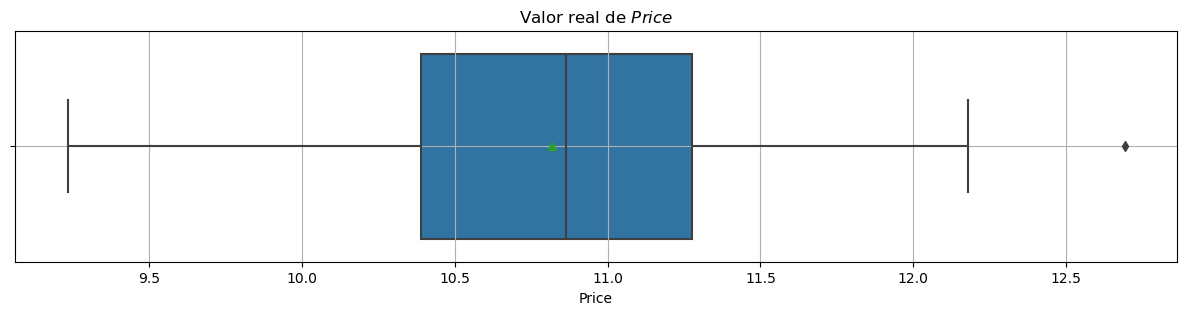

In [241]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{Price}$')
plt.grid()
plt.show()

In [242]:
y_test.describe()

count    234.000000
mean      10.817837
std        0.618294
min        9.232535
25%       10.389423
50%       10.862093
75%       11.276708
max       12.691441
Name: Price, dtype: float64

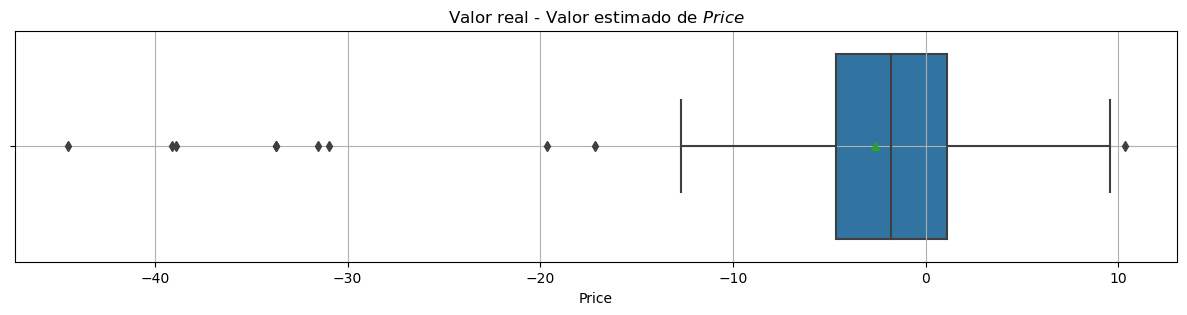

In [243]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = (y_test - regression.predict(X_test)), showmeans = True, orient = 'h')
plt.title('Valor real - Valor estimado de $\t{Price}$')
plt.grid()
plt.show()

In [244]:
abs(y_test - regression.predict(X_test)).describe()

count    234.000000
mean       4.459249
std        6.340891
min        0.001155
25%        1.330460
50%        2.877269
75%        5.343428
max       44.530401
Name: Price, dtype: float64

# 5. Comprobación de supuestos

### 5.1. Correlación
Se acepta un nivel de correlación menor a ~$|0.8|$.

,Ram,Weight,Ppi,HDD,SSD
Ram,1.000000,0.091154,0.043242,0.088890,0.596536
Weight,0.091154,1.000000,-0.019015,0.096651,-0.001271
Ppi,0.043242,-0.019015,1.000000,-0.065486,0.089405
HDD,0.088890,0.096651,-0.065486,1.000000,-0.403111
SSD,0.596536,-0.001271,0.089405,-0.403111,1.000000


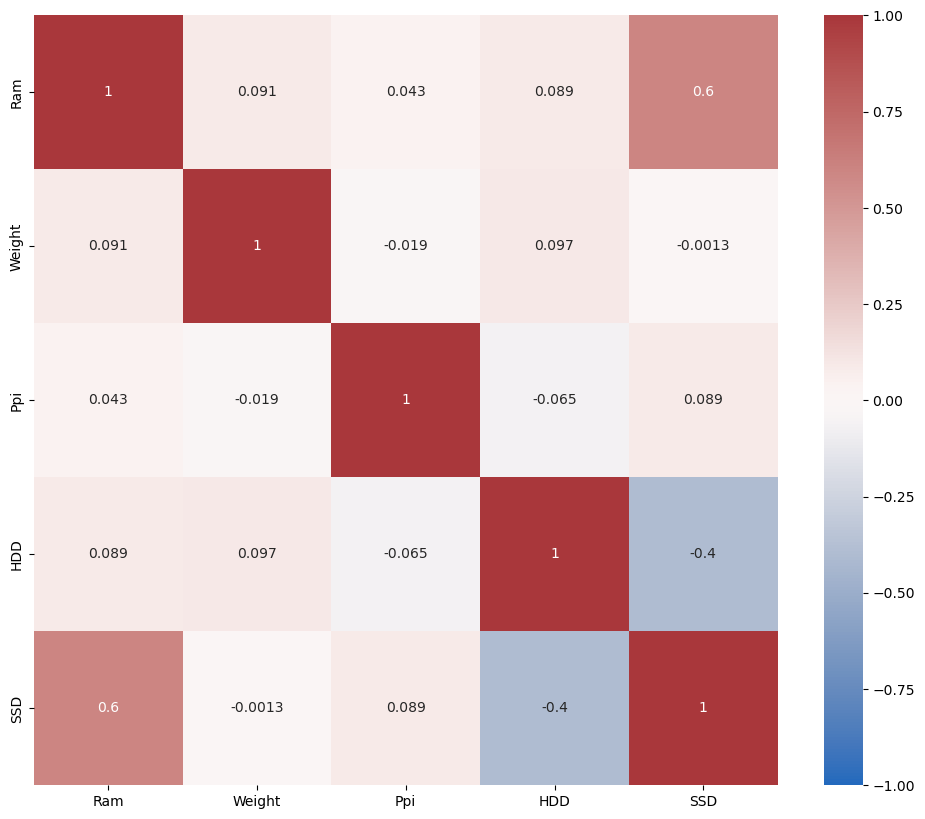

In [245]:
# Correlacion entre variables numericas
plt.figure(figsize = (12, 10))
sns.heatmap(df_laptops_train[featuresNumericas].corr(), annot=True,cmap = 'vlag', vmin = -1, vmax = 1)
df_laptops_train[featuresNumericas].corr()


### 5.2. Homocedasticidad

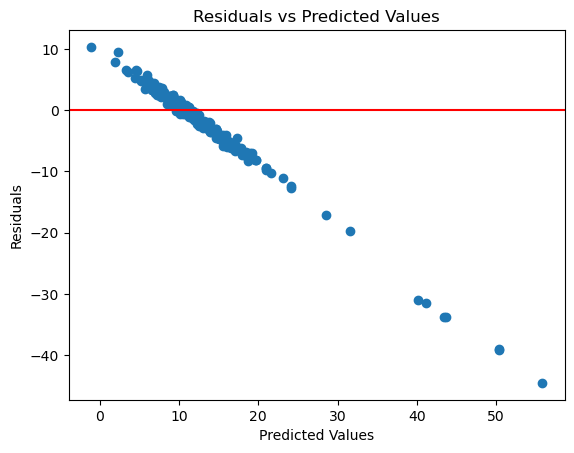

In [246]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


#### 5.3 Normalidad

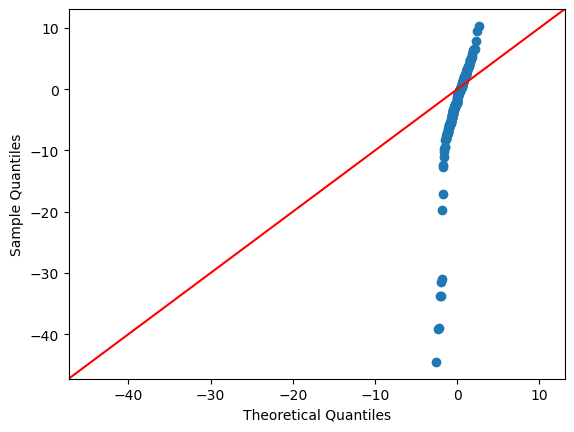

In [247]:
sm.qqplot(residuals, line='45')
plt.show()


#### 5.4. Multicolinealidad

In [248]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)


                           Variable        VIF
0                               Ram   9.095788
1                            Weight   1.522514
2                               Ppi   1.614721
3                               HDD   3.296431
4                               SSD   5.602468
5                      Company_Asus   2.588417
6                      Company_Dell   4.226538
7                        Company_HP   3.402205
8                    Company_Lenovo   3.664071
9                       Company_MSI   1.998859
10                 Company_Mediacom   1.106579
11           Company_Others_Company   1.887383
12                  Company_Toshiba   1.585200
13                  TypeName_Gaming   6.572586
14                 TypeName_Netbook   1.308928
15                TypeName_Notebook  11.270006
16         TypeName_Others_TypeName   1.776700
17               TypeName_Ultrabook   3.617688
18                    TouchScreen_1   2.699922
19                            Ips_1   1.925655
20          C

In [249]:
# Revisar datos atípicos numericamente
df_laptops_train[featuresNumericas].describe()

,Ram,Weight,Ppi,HDD,SSD
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,8.507719,2.132753,151.778302,414.802744,187.989708
std,5.136040,2.882080,181.493944,517.624081,187.302367
min,2.000000,0.690000,90.583402,0.000000,0.000000
25%,4.000000,1.500000,127.335675,0.000000,0.000000
50%,8.000000,2.040000,141.211998,0.000000,256.000000
75%,8.000000,2.310000,157.350512,1000.000000,256.000000
max,64.000000,97.729949,6170.032609,2000.000000,1024.000000


# 32. Eliminando outliders

In [250]:
df_laptops_train_copia2 = df_laptops_train.copy()
df_laptops_train_copia2

,Price,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows
0,10.084809,4,1.90,100.454670,500.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,10.563111,8,1.98,141.211998,1000.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,11.064804,8,1.26,176.232574,0.0,256,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,10.977717,12,2.26,141.211998,2000.0,512,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,11.550633,8,1.21,331.264236,0.0,256,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,10.893771,8,1.64,157.350512,0.0,256,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1162,9.950617,4,2.20,100.454670,500.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1163,11.395541,8,1.80,157.350512,0.0,256,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1164,10.082584,4,2.00,100.454670,1000.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


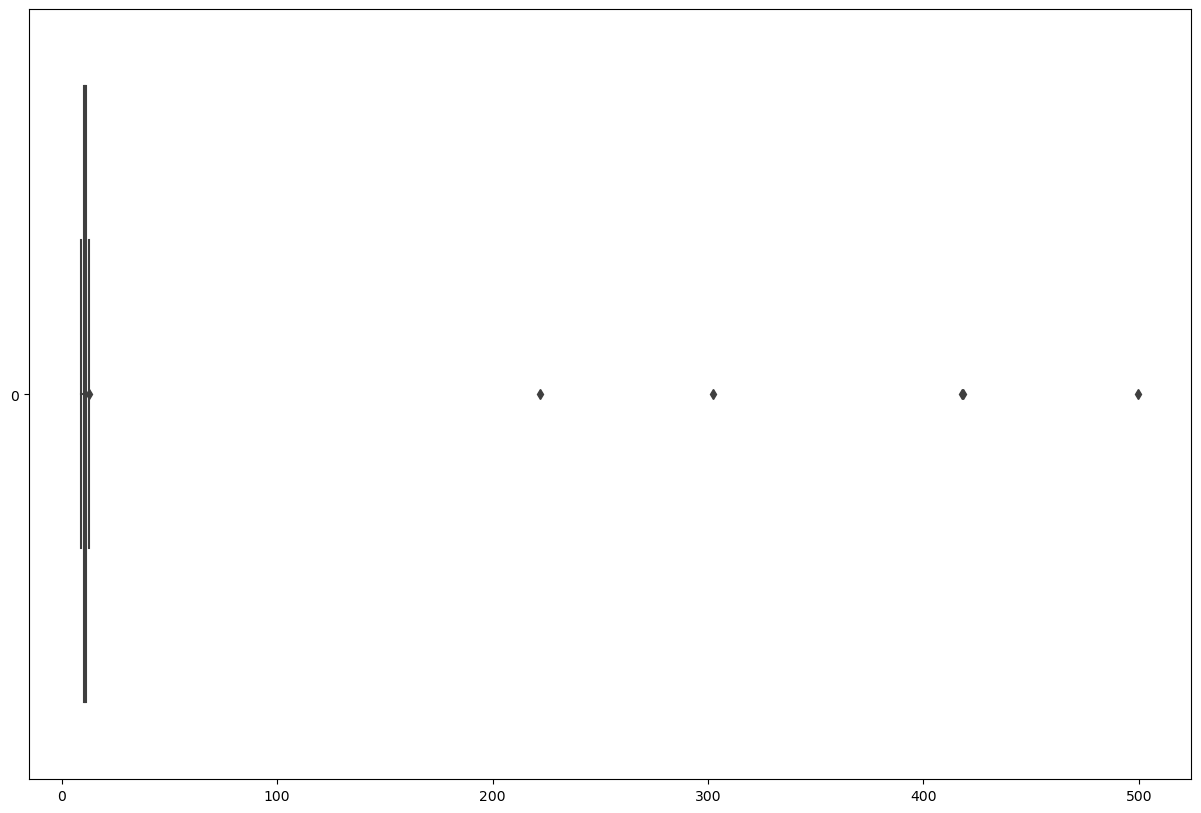

In [253]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df_laptops_train_copia2["Price"], orient='h')
plt.show()

In [254]:
q = df_laptops_train_copia2["Price"].quantile(0.75)
df_laptops_train_copia2 = df_laptops_train_copia2[df_laptops_train_copia2["Price"] < q]
df_laptops_train_copia2

,Price,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows
0,10.084809,4,1.90,100.454670,500.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,10.563111,8,1.98,141.211998,1000.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,11.064804,8,1.26,176.232574,0.0,256,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,10.977717,12,2.26,141.211998,2000.0,512,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
5,11.018721,8,2.10,127.335675,1000.0,128,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,10.594300,8,2.37,141.211998,1000.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1160,10.994858,8,1.70,141.211998,0.0,256,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1161,10.893771,8,1.64,157.350512,0.0,256,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1162,9.950617,4,2.20,100.454670,500.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


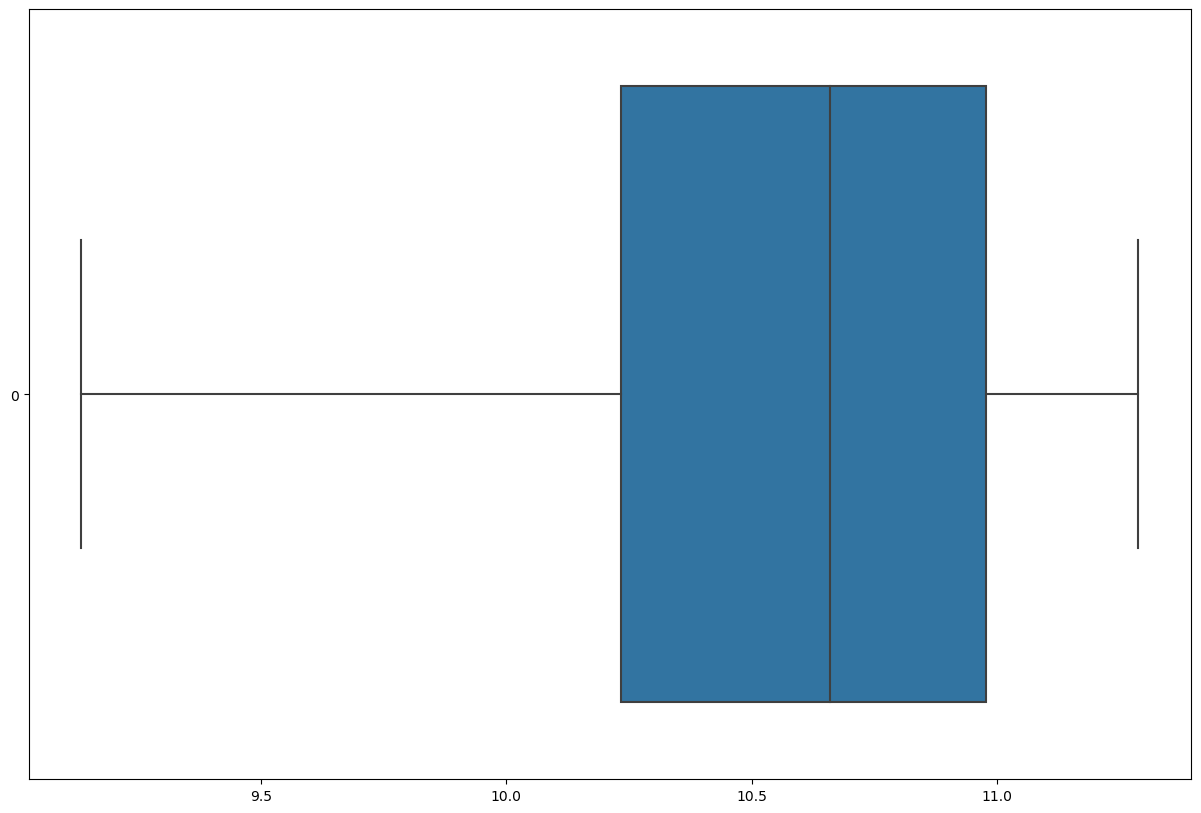

In [255]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df_laptops_train_copia2["Price"], orient='h')
plt.show()

In [256]:
#  Modelo sin outliders
featuresActualizadas2 = list(df_laptops_train_copia2.columns)
featuresActualizadas2.remove('Price')
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_laptops_train_copia2[featuresActualizadas2], df_laptops_train_copia2['Price'], test_size = 0.2, random_state = 1)
print(featuresActualizadas2)

['Ram', 'Weight', 'Ppi', 'HDD', 'SSD', 'Company_Asus', 'Company_Dell', 'Company_HP', 'Company_Lenovo', 'Company_MSI', 'Company_Mediacom', 'Company_Others_Company', 'Company_Toshiba', 'TypeName_Gaming', 'TypeName_Netbook', 'TypeName_Notebook', 'TypeName_Others_TypeName', 'TypeName_Ultrabook', 'TouchScreen_1', 'Ips_1', 'Cpu_brand_Intel Core i3', 'Cpu_brand_Intel Core i5', 'Cpu_brand_Intel Core i7', 'Cpu_brand_Other Intel Processor', 'Gpu_brand_Intel', 'Gpu_brand_Nvidia', 'Os_Windows']


In [257]:
X_train2.describe()

,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,6.965517,2.168417,144.659039,453.534483,129.844828,0.120690,0.228448,0.219828,0.218391,0.027299,0.007184,0.037356,0.037356,0.119253,0.015805,0.698276,0.002874,0.093391,0.099138,0.219828,0.143678,0.379310,0.287356,0.125000,0.550287,0.270115,0.843391
std,3.245178,3.658055,230.673476,524.376592,134.313792,0.326001,0.420135,0.414428,0.413451,0.163070,0.084514,0.189770,0.189770,0.324319,0.124809,0.459336,0.053567,0.291189,0.299062,0.414428,0.351015,0.485564,0.452855,0.330957,0.497823,0.444338,0.363693
min,2.000000,0.690000,90.583402,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.700000,111.935204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,8.000000,2.100000,141.211998,0.000000,128.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,8.000000,2.300000,141.211998,1000.000000,256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,32.000000,97.729949,6170.032609,2000.000000,512.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [258]:
X_train2[X_train2.isnull().any(axis=1)]

,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows


In [259]:
regression2 = LinearRegression()

In [260]:
X_train2.isnull().sum()

Ram                                0
Weight                             0
Ppi                                0
HDD                                0
SSD                                0
Company_Asus                       0
Company_Dell                       0
Company_HP                         0
Company_Lenovo                     0
Company_MSI                        0
Company_Mediacom                   0
Company_Others_Company             0
Company_Toshiba                    0
TypeName_Gaming                    0
TypeName_Netbook                   0
TypeName_Notebook                  0
TypeName_Others_TypeName           0
TypeName_Ultrabook                 0
TouchScreen_1                      0
Ips_1                              0
Cpu_brand_Intel Core i3            0
Cpu_brand_Intel Core i5            0
Cpu_brand_Intel Core i7            0
Cpu_brand_Other Intel Processor    0
Gpu_brand_Intel                    0
Gpu_brand_Nvidia                   0
Os_Windows                         0
d

In [261]:
regression2.fit(X_train2, y_train2)

LinearRegression()

In [262]:
pd.DataFrame(regression2.coef_, index=X_train2.columns, columns=['Coeficiente'])

,Coeficiente
Ram,0.020390
Weight,-0.002458
Ppi,0.000034
HDD,0.000047
SSD,0.000792
Company_Asus,0.085191
Company_Dell,0.163317
Company_HP,0.152393
Company_Lenovo,0.074089
Company_MSI,0.212607


In [263]:
regression2.intercept_

9.823855991666912

<Axes: >

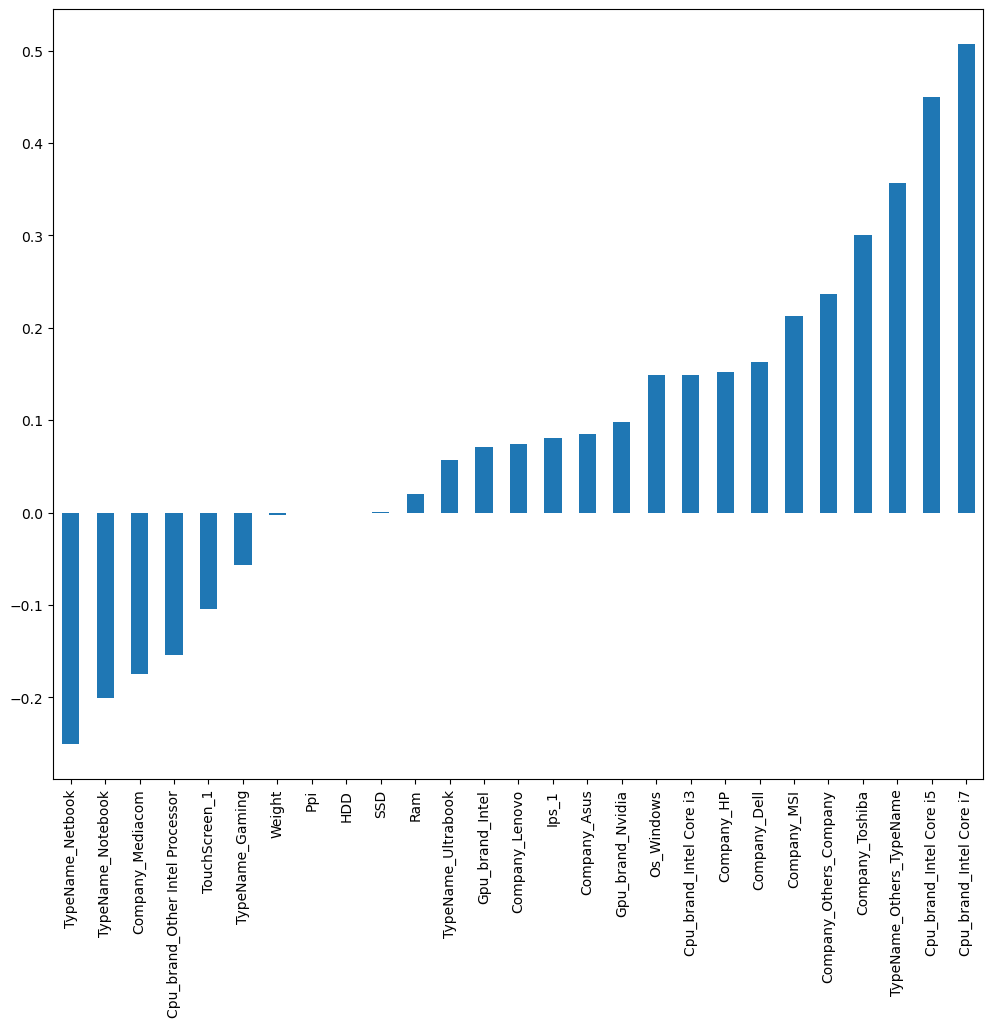

In [264]:
pd.Series(regression2.coef_, index=X_train2.columns).sort_values().plot(kind='bar', figsize=(12, 10))

In [265]:
X_train_sm2 = sm.add_constant(X_train2)

model2 = sm.OLS(y_train2, X_train_sm2).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     88.65
Date:                Sat, 16 Sep 2023   Prob (F-statistic):          1.84e-200
Time:                        17:17:44   Log-Likelihood:                 58.914
No. Observations:                 696   AIC:                            -61.83
Df Residuals:                     668   BIC:                             65.44
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               9.8239      0.077    127.400      0.000       9.672       9.975
Ram                                 0.0204      0.004      5.063      0.000       0.012       0.028
Weight                             -0.0025      0.002     -1.029      0.304      -0.007       0.002
Ppi                              3.376e-05   3.76e-05      0.897      0.370   -4.01e-05       0.000
HDD                              4.746e-05   2.47e-05      1.924      0.055   -9.77e-07    9.59e-05
SSD                                 0.0008      0.000      7.578      0.000       0.001       0.001
Company_Asus                        0.0852      0.038      2.251      0.025       0.011       0.160
Company_Dell                        0.1633      0.036      4.557      0.000       0.093       0.234
Company_HP                          0.1524      0.034      4.503      0.000       0.086       0.219
Company_Lenovo                      0.0741      0.033      2.234      0.026       0.009       0.139
Company_MSI                         0.2126      0.068      3.109      0.002       0.078       0.347
Company_Mediacom                   -0.1748      0.110     -1.591      0.112      -0.391       0.041
Company_Others_Company              0.2365      0.057      4.165      0.000       0.125       0.348
Company_Toshiba                     0.3001      0.054      5.537      0.000       0.194       0.407
TypeName_Gaming                    -0.0566      0.068     -0.832      0.406      -0.190       0.077
TypeName_Netbook                   -0.2508      0.092     -2.725      0.007      -0.432      -0.070
TypeName_Notebook                  -0.2001      0.059     -3.370      0.001      -0.317      -0.083
TypeName_Others_TypeName            0.3562      0.173      2.054      0.040       0.016       0.697
TypeName_Ultrabook                  0.0569      0.060      0.952      0.341      -0.060       0.174
TouchScreen_1                      -0.1040      0.051     -2.058      0.040      -0.203      -0.005
Ips_1                               0.0809      0.025      3.302      0.001       0.033       0.129
Cpu_brand_Intel Core i3             0.1494      0.051      2.918      0.004       0.049       0.250
Cpu_brand_Intel Core i5             0.4496      0.048      9.395      0.000       0.356       0.544
Cpu_brand_Intel Core i7             0.5067      0.050     10.236      0.000       0.410       0.604
Cpu_brand_Other Intel Processor    -0.1540      0.055     -2.777      0.006      -0.263      -0.045
Gpu_brand_Intel                     0.0709      0.033      2.159      0.031       0.006       0.135
Gpu_brand_Nvidia                    0.0978      0.037      2.649      0.008       0.025       0.170
Os_Windows                          0.1492      0.025      5.860      0.000       0

In [266]:

y_pred2 = regression2.predict(X_test2)

In [267]:
# MAE
print('Train:', mean_absolute_error(y_train2, regression2.predict(X_train2)))
print('Test:', mean_absolute_error(y_test2, y_pred2))

Train: 0.17380985457861425
Test: 0.2018047081784105


In [268]:
# RMSE
print('Train:', np.sqrt(mean_squared_error(y_train2, regression2.predict(X_train2))))
print('Test:', np.sqrt(mean_squared_error(y_test2, y_pred2)))

Train: 0.2223316837271974
Test: 0.2579411321458264


In [269]:
# R2
print('Train:', r2_score(y_train2, regression2.predict(X_train2)))
print('Test:', r2_score(y_test2, y_pred2))

Train: 0.7818029878123025
Test: 0.7309592901221008


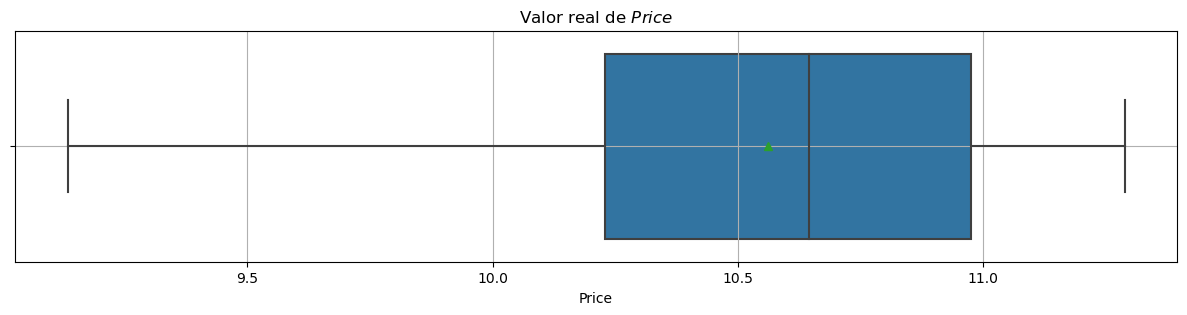

In [270]:
# Análisis del error
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test2, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{Price}$')
plt.grid()
plt.show()

In [271]:

y_test2.describe()

count    174.000000
mean      10.560838
std        0.498727
min        9.134616
25%       10.229685
50%       10.645571
75%       10.974527
max       11.287447
Name: Price, dtype: float64

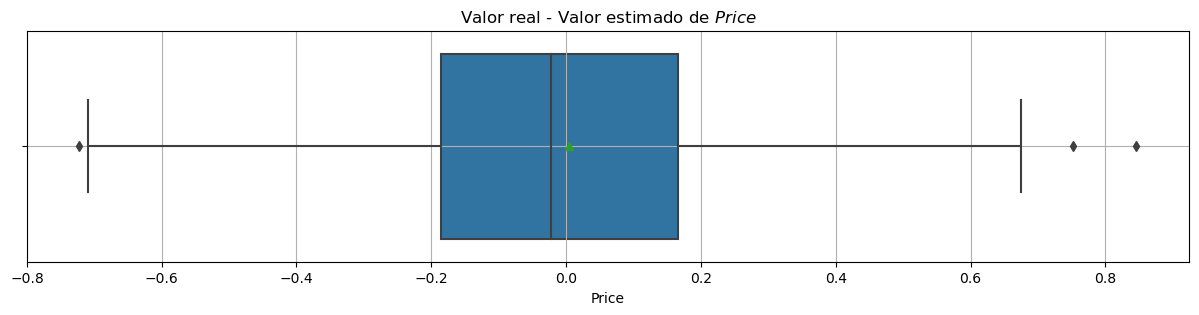

In [272]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = (y_test2 - regression2.predict(X_test2)), showmeans = True, orient = 'h')
plt.title('Valor real - Valor estimado de $\t{Price}$')
plt.grid()
plt.show()

In [273]:
abs(y_test2 - regression2.predict(X_test2)).describe()

count    174.000000
mean       0.201805
std        0.161114
min        0.000581
25%        0.090378
50%        0.173025
75%        0.270772
max        0.845857
Name: Price, dtype: float64

,Ram,Weight,Ppi,HDD,SSD
Ram,1.000000,0.091154,0.043242,0.088890,0.596536
Weight,0.091154,1.000000,-0.019015,0.096651,-0.001271
Ppi,0.043242,-0.019015,1.000000,-0.065486,0.089405
HDD,0.088890,0.096651,-0.065486,1.000000,-0.403111
SSD,0.596536,-0.001271,0.089405,-0.403111,1.000000


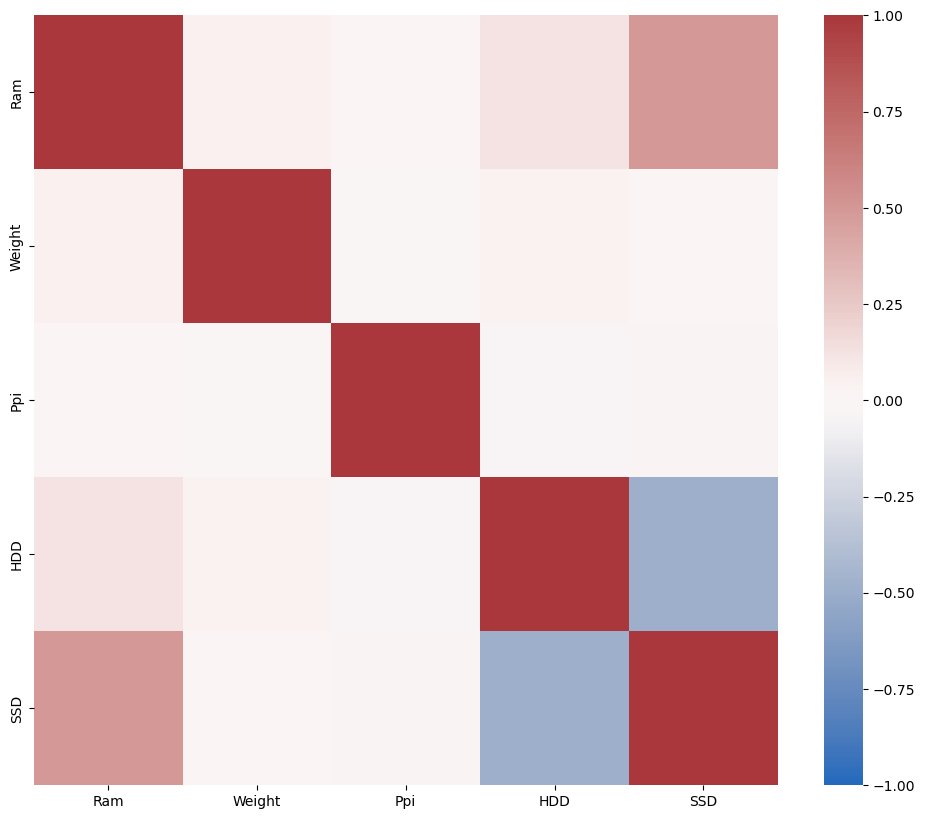

In [274]:
# Correlacion entre variables numericas
plt.figure(figsize = (12, 10))
sns.heatmap(df_laptops_train_copia2[featuresNumericas].corr(), cmap = 'vlag', vmin = -1, vmax = 1)
df_laptops_train[featuresNumericas].corr()

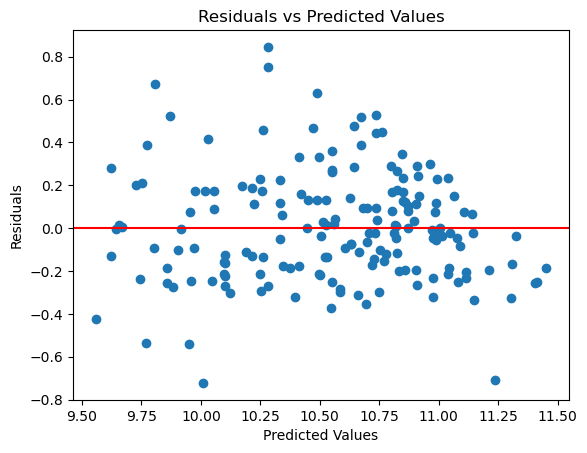

In [275]:

residuals2 = y_test2 - y_pred2
plt.scatter(y_pred2, residuals2)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

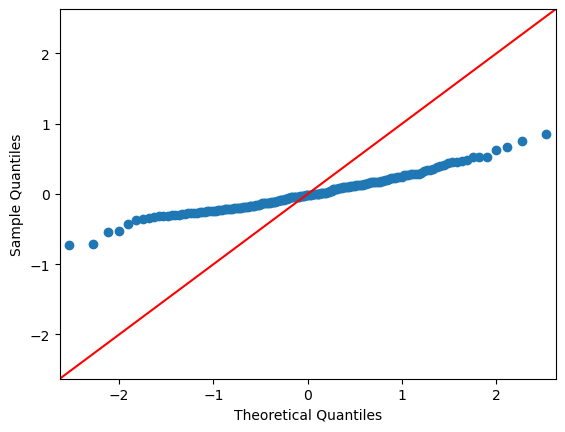

In [276]:
sm.qqplot(residuals2, line='45')
plt.show()

In [277]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data2 = pd.DataFrame()
vif_data2["Variable"] = X_train2.columns
vif_data2["VIF"] = [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])]
print(vif_data2)

                           Variable        VIF
0                               Ram  12.665901
1                            Weight   1.390030
2                               Ppi   1.413169
3                               HDD   3.924264
4                               SSD   5.119620
5                      Company_Asus   2.198877
6                      Company_Dell   3.809606
7                        Company_HP   3.177951
8                    Company_Lenovo   3.037852
9                       Company_MSI   1.688921
10                 Company_Mediacom   1.170048
11           Company_Others_Company   1.605294
12                  Company_Toshiba   1.468831
13                  TypeName_Gaming   5.105570
14                 TypeName_Netbook   1.416167
15                TypeName_Notebook  15.392230
16         TypeName_Others_TypeName   1.096146
17               TypeName_Ultrabook   2.781907
18                    TouchScreen_1   2.384594
19                            Ips_1   1.762340
20          C

# 6. Pipeline

In [251]:
# Crear un pipeline para el modelo de regresion lineal

# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), featuresNumericas),
        ('encoder', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), featuresCategoricas)
    ]
)

# Limpieza de datos
